<a href="https://colab.research.google.com/github/wiwianaa/AnalizaSentymentu/blob/main/datalabelling_w_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Przygotowanie środowiska

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tweepy
#!pip install gensim
#!pip install -U pip setuptools wheel
#!pip install -U 'spacy[cuda-autodetect]'

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
#!python -m pip install spacy==3.4.0 -q
!python -m spacy download pl_core_news_lg # końcówka _lg oznacza rozmiar modelu, mamy jeszcze sm czyli small i md czyli medium

2023-05-23 19:27:19.639438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 19:27:20.655822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-23 19:27:22.565777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-23 19:27:22.566290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [3]:
#biblioteki
import tweepy
import pandas as pd
import spacy
import json
from scipy import spatial # biblioteka do obliczeń
from spacy import displacy # wizualizacja drzewa zaleznosci
nlp = spacy.load('pl_core_news_lg') # zwyczajowo nazywamy zmienną do modelu nlp
# pomocnicze
import re
import numpy as np
import string
# wizualizacja
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
#gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
# import potrzebnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# system
#import os
#import shutil

# tf
import tensorflow as tf

#filter warnings
import warnings
warnings.filterwarnings('ignore')

#karas
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Pobieranie danych

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Praca dyplomowa/tweets_manual.csv", encoding="utf-8") 
data = data[["tweets", "likes", "time", "test"]]
data['tweets'].drop_duplicates(keep="first", inplace=True)
data = data[~data.tweets.str.contains("wizerun")] # zagadnienia nie zgodne z tematem
#data['tweets'] = data['tweets'].str.encode("utf-8")
print(data.size)
data.head()

56272


,tweets,likes,time,test
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,0,2022-01-15 11:41:23,NaN
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,6,2022-01-15 11:34:24,NaN
3,💬Globalne ocieplenie powoduje coraz częstsze i...,7,2022-01-15 11:24:55,NaN
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,0,2022-01-15 11:09:12,NaN
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,13,2022-01-15 11:09:07,NaN


Data cleaning

In [5]:
def clean_text(text):
  text = text.lower()
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
  text = re.sub('\$[a-zA-Z0-9_]*', ' ', text)
  text = re.sub('\@[AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpQqRrSsŚśTtUuWwVvYyZzŹźŻż0-9_]*', ' ', text)
  text = re.sub('[^[AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpQqRrSsŚśTtUuWwVvYyZzŹźŻż\']', ' ', text)
  text = re.sub('\t', '', text)
  text = re.sub('\n', ' ', text)
  text = [w for w in text.split() if len(w)>2]
  #text = " ".join([word for word in str(text).split() if word not in stopwordlist])
  return text

In [6]:
data['clean_tweet'] = data['tweets'].apply(clean_text)
data['cleaned_tweet'] = data['clean_tweet'].apply(lambda x:' '.join(x))
data.head()

,tweets,likes,time,test,clean_tweet,cleaned_tweet
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,0,2022-01-15 11:41:23,NaN,"[jedno, mnie, zastanawia, wpływ, ludzkiego, oc...",jedno mnie zastanawia wpływ ludzkiego ocieplen...
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,6,2022-01-15 11:34:24,NaN,"[posłanka, zielonyodbudowy, globalne, ocieplen...",posłanka zielonyodbudowy globalne ocieplenie p...
3,💬Globalne ocieplenie powoduje coraz częstsze i...,7,2022-01-15 11:24:55,NaN,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalne ocieplenie powoduje coraz częstsze co...
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,0,2022-01-15 11:09:12,NaN,"[małgorzata, tracz, dodał, tweeta, treść, glob...",małgorzata tracz dodał tweeta treść globalne o...
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,13,2022-01-15 11:09:07,NaN,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalne ocieplenie powoduje coraz częstsze co...


In [7]:
#lematyzacja
#lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    tokens = nlp(data)
    tokens = [token.lemma_ for token in tokens]
    return tokens
data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: lemmatizer_on_text(x))
data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x:' '.join(x))
data.head()

,tweets,likes,time,test,clean_tweet,cleaned_tweet
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,0,2022-01-15 11:41:23,NaN,"[jedno, mnie, zastanawia, wpływ, ludzkiego, oc...",jeden ja zastanawiać wpływ ludzki ocieplenie k...
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,6,2022-01-15 11:34:24,NaN,"[posłanka, zielonyodbudowy, globalne, ocieplen...",posłanka zielonyodbudowy globalny ocieplenie p...
3,💬Globalne ocieplenie powoduje coraz częstsze i...,7,2022-01-15 11:24:55,NaN,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalny ocieplenie powodować coraz częstsze c...
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,0,2022-01-15 11:09:12,NaN,"[małgorzata, tracz, dodał, tweeta, treść, glob...",Małgorzata tracz dodać tweet treść globalny oc...
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,13,2022-01-15 11:09:07,NaN,"[globalne, ocieplenie, powoduje, coraz, częsts...",globalny ocieplenie powodować coraz częstsze c...


In [8]:
stopwordlist = nlp.Defaults.stop_words
def remove_stopwords(text):
  text = " ".join([word for word in str(text).split() if word not in stopwordlist])
  return text
data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_stopwords)
data = data.drop_duplicates(subset=['cleaned_tweet'], keep="first")
#data['clean_tweet'] = data['cleaned_tweet']
#data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x:' '.join(x))
data = data.drop(['time', 'likes', 'clean_tweet'], axis=1)
data.head()


,tweets,test,cleaned_tweet
0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,NaN,zastanawiać wpływ ludzki ocieplenie klimat udo...
2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,NaN,posłanka zielonyodbudowy globalny ocieplenie p...
3,💬Globalne ocieplenie powoduje coraz częstsze i...,NaN,globalny ocieplenie powodować częstsze długo t...
4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,NaN,Małgorzata tracz dodać tweet treść globalny oc...
5,💬 – Globalne ocieplenie powoduje coraz częstsz...,NaN,globalny ocieplenie powodować częstsze długo t...


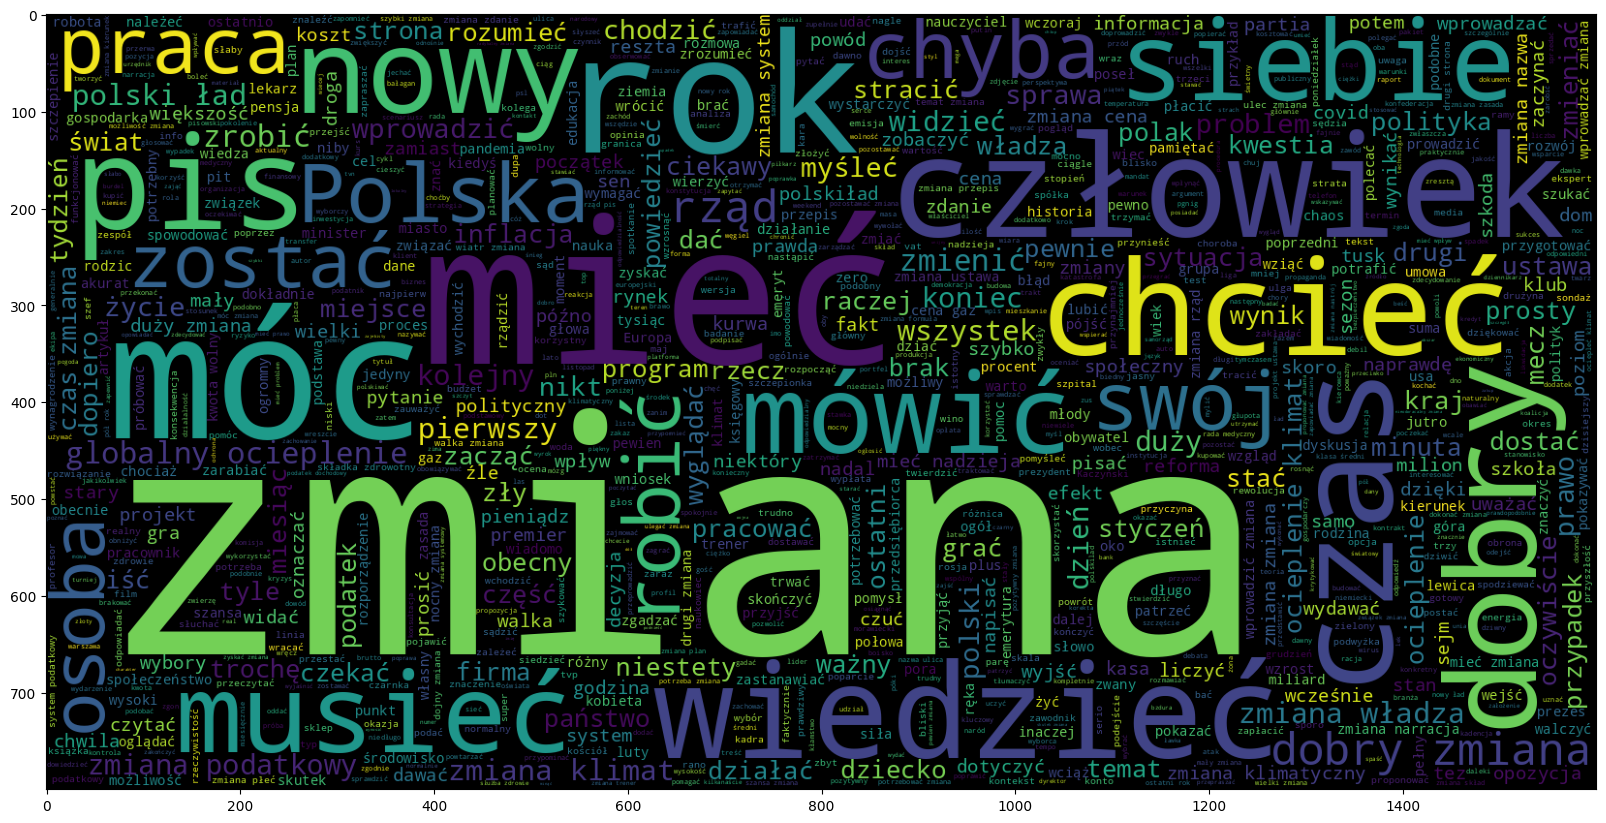

In [9]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=True).generate(" ".join(data['cleaned_tweet']))
plt.imshow(wc)

In [10]:
data.to_csv('/content/drive/MyDrive/Praca dyplomowa/tweets_cleaned.csv')

Data labelling

In [11]:
#data = pd.read_csv("/content/drive/MyDrive/ZUM/tweets_cleaned.csv")
#print(data.dtypes)
#data

In [12]:
X=data['cleaned_tweet']
X = X.apply(lambda x:x.split())
#X.dtypes

In [13]:
sent = [row for row in X]

phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [14]:
len(sentences)

11662

In [15]:
#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50).fit(tweets)

Proba testow parametrów?

In [ ]:
from gensim.test.utils import common_texts
from gensim.matutils import corpus2csc

sentances_list = []

for i in sentences:
  sentances_list.append(i)
#sentances_csr = corpus2csc(sentences)
print(common_texts)
#type(sentances_csr)
sentances_list

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]


[['zastanawiać',
  'wpływ',
  'ludzki',
  'ocieplenie_klimat',
  'udowodnić',
  'zjawisko_globalny',
  'ocieplenie',
  'przewidzieć',
  'wiek',
  'dawać',
  'grant',
  'właściwie',
  'cel'],
 ['posłanka',
  'zielonyodbudowy_globalny',
  'ocieplenie_powodować',
  'częstsze_długo',
  'trwać_ekstremi',
  'pogodowy_gwałtowny',
  'ulewa_fala',
  'upał_susz',
  'zjawisko_dotykać',
  'wszystek_region',
  'świat_zielonyplanodbudowy',
  'zielonimająplan_kongreszielony'],
 ['globalny_ocieplenie',
  'powodować_częstsze',
  'długo_trwać',
  'ekstremi_pogodowy',
  'gwałtowny_ulewa',
  'fala_upał',
  'susz_zjawisko',
  'dotykać_wszystek',
  'region_świat',
  'zielonyplanodbudowy_zielonimająplan',
  'kongreszielony'],
 ['Małgorzata_tracz',
  'dodać_tweet',
  'treść',
  'globalny_ocieplenie',
  'powodować_częstsze',
  'długo_trwać',
  'ekstremi_pogodowy',
  'gwałtowny_ulewa',
  'fala'],
 ['globalny_ocieplenie',
  'powodować_częstsze',
  'długo_trwać',
  'ekstremi_pogodowy',
  'gwałtowny_ulewa',
  'fal

In [ ]:
from sklearn.pipeline import Pipeline

param_grid = {
    'word2vec__size': [50, 100, 200],
    'word2vec__window': [2, 5, 10],
    'word2vec__sg': [0, 1],
}

# Initialize word2vec model
w2v = Word2Vec(min_count=5, workers=4)
pipeline = Pipeline([
    ('word2vec', w2v),
])

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
#grid_search.build_vocab(sentences)
grid_search.fit(sentences)

# Print best hyperparameters and their score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


AttributeError: ignored

word to vec

In [16]:
# inicjalizacja modelu word2vec

import multiprocessing


w2v_model = Word2Vec(min_count=4,
                     window=5,
                     vector_size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)

#print(w2v_model)
w2v_model.build_vocab(sentences, progress_per=50000)

In [17]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.wv.most_similar(positive=["ściema"])

[('odszkodowanie', 0.9997872114181519),
 ('przekazać', 0.9997765421867371),
 ('komunikacja', 0.9997652173042297),
 ('świetnie', 0.9997634887695312),
 ('rzekomo', 0.999762237071991),
 ('odejście', 0.9997605085372925),
 ('dyskutować', 0.9997600317001343),
 ('strategia', 0.9997599720954895),
 ('prąd', 0.9997560977935791),
 ('wyliczyć', 0.9997557997703552)]

In [18]:
#w2v_model.save("word2vec.model_archive")
w2v_model.save("word2vec.model")
#word2vec_model.save("word2vec_pretrained.model")

In [19]:
word_vectors = Word2Vec.load("word2vec.model").wv
word_vectors.vectors.astype('double')
#word_vectors = word2vec_model.wv
#word_vectors = Word2Vec.load("word2vec_pretrained.model").wv

array([[-0.01164779,  0.00834416, -0.02450063, ..., -0.01691009,
         0.03570998,  0.05660294],
       [-0.01031906,  0.00820189, -0.02869229, ..., -0.01533997,
         0.03926214,  0.06055611],
       [-0.00855248,  0.00811656, -0.02480493, ..., -0.02139345,
         0.03643823,  0.06146208],
       ...,
       [-0.00550239,  0.00574641, -0.02467416, ..., -0.01727688,
         0.03413055,  0.05432618],
       [-0.00704519,  0.00733955, -0.02429453, ..., -0.01521305,
         0.04185571,  0.05803767],
       [-0.00849504,  0.00874078, -0.02040165, ..., -0.01352627,
         0.03571102,  0.0518989 ]])

In [20]:
word_vectors[1]

array([-1.03190551e-02,  8.20188504e-03, -2.86922902e-02, -6.35188445e-02,
       -1.44670337e-01,  8.94449875e-02,  9.35788080e-02,  2.28571892e-02,
        1.22150242e-01,  1.94860324e-01,  3.30150872e-01,  2.03018151e-02,
       -1.32061988e-01,  3.19082767e-01, -6.09537549e-02, -1.29434019e-02,
        1.18713945e-01, -1.07496172e-01, -1.55253276e-01, -5.45045026e-02,
        1.03369929e-01,  8.21525604e-02,  1.11811750e-01,  2.54904300e-01,
        6.78491145e-02,  1.61527749e-02, -1.47799358e-01, -7.96596333e-02,
        1.85913593e-02,  6.54777065e-02, -1.50285035e-01,  4.39511314e-02,
       -2.74942275e-02, -3.46894003e-02,  1.05330922e-01,  1.17850497e-01,
        3.65887247e-02, -6.79428428e-02, -7.86355287e-02,  6.63526170e-03,
        9.94847864e-02, -6.76070945e-03, -1.11603122e-02,  6.87280744e-02,
       -1.52829541e-02, -9.62028578e-02,  1.03655174e-01,  1.61630943e-01,
        7.90176447e-03,  1.79586470e-01, -1.31149255e-02, -1.60192534e-01,
       -5.42236865e-02, -

Proba knn zamiast kmeans z uwzglednieniem istotnych słów

In [21]:
word_vectors.vectors.astype('double')

array([[-0.01164779,  0.00834416, -0.02450063, ..., -0.01691009,
         0.03570998,  0.05660294],
       [-0.01031906,  0.00820189, -0.02869229, ..., -0.01533997,
         0.03926214,  0.06055611],
       [-0.00855248,  0.00811656, -0.02480493, ..., -0.02139345,
         0.03643823,  0.06146208],
       ...,
       [-0.00550239,  0.00574641, -0.02467416, ..., -0.01727688,
         0.03413055,  0.05432618],
       [-0.00704519,  0.00733955, -0.02429453, ..., -0.01521305,
         0.04185571,  0.05803767],
       [-0.00849504,  0.00874078, -0.02040165, ..., -0.01352627,
         0.03571102,  0.0518989 ]])

In [22]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
#words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
#words.cluster = words.cluster.apply(lambda x: x[0])
words

,words,vectors
0,zmiana,"[-0.01164779, 0.008344158, -0.02450063, -0.065..."
1,mieć,"[-0.010319055, 0.008201885, -0.02869229, -0.06..."
2,móc,"[-0.00855248, 0.008116557, -0.024804933, -0.06..."
3,rok,"[-0.01267526, 0.0034963242, -0.028086506, -0.0..."
4,dobry,"[-0.0071006757, 0.0066117067, -0.02277736, -0...."
...,...,...
5806,wjechać,"[-0.0057370206, 0.008612713, -0.025185984, -0...."
5807,przygłup,"[-0.0087369075, 0.0026467808, -0.026218409, -0..."
5808,timmermans,"[-0.0055023925, 0.0057464093, -0.024674157, -0..."
5809,hamulcowy,"[-0.00704519, 0.00733955, -0.024294525, -0.067..."


In [23]:
beliver = ['ważny','wpływ', 'działanie', 'nagły', 'walka', 'prowadzić', 'świadomość', 'problem', 'powodować', 'kryzys', 'niebezpieczeństwo']
denier = ['teoria','wierzyć','istnieć', 'wymyślić', 'dowód', 'tłumaczyć', 'cykliczny', 'oszustwo', 'ściema', "woda_mózg"]

for i in beliver:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
for i in denier:
    words.loc[words["words"]==i,"cluster_value"] = 0

In [102]:
word_train = words[words["cluster_value"]>=0]
word_train['vectors'] = word_train.vectors.apply(lambda x: vector(np.array(x)))
word_train

,words,vectors,cluster_value
42,problem,"[-0.0074511016719043255, 0.004558103624731302,...",1.0
58,ważny,"[-0.009295529685914516, 0.00453657191246748, -...",1.0
107,walka,"[-0.010265856981277466, 0.0076573132537305355,...",1.0
173,wpływ,"[-0.011438103392720222, 0.006050392985343933, ...",1.0
191,wierzyć,"[-0.00701809860765934, 0.009448857977986336, -...",0.0
227,prowadzić,"[-0.011223782785236835, 0.009577260352671146, ...",1.0
251,działanie,"[-0.01218098308891058, 0.0064345067366957664, ...",1.0
357,istnieć,"[-0.010776067152619362, 0.009436799213290215, ...",0.0
372,powodować,"[-0.01043907180428505, 0.0029362833593040705, ...",1.0
552,tłumaczyć,"[-0.009777484461665154, 0.004056703299283981, ...",0.0


In [113]:
test = words[words["words"]=="komunikacja"]
test

,words,vectors,cluster_value
1330,komunikacja,"[-0.0073713744, 0.0057653002, -0.029120238, -0...",NaN


In [104]:
type(test["cluster_value"].loc[1330])

numpy.float64

In [105]:
np.array(list(word_train["vectors"]), dtype=np.float)

array([[-0.0074511 ,  0.0045581 , -0.02244399, ..., -0.01601854,
         0.03752238,  0.06046583],
       [-0.00929553,  0.00453657, -0.02773619, ..., -0.01525846,
         0.03570194,  0.06260906],
       [-0.01026586,  0.00765731, -0.02720091, ..., -0.01926533,
         0.03889193,  0.0573057 ],
       ...,
       [-0.00929554,  0.00760273, -0.02638021, ..., -0.01749841,
         0.03438004,  0.05549329],
       [-0.01036309,  0.00262431, -0.02562287, ..., -0.01361974,
         0.03752508,  0.05177448],
       [-0.01028662,  0.00455423, -0.02770833, ..., -0.01733186,
         0.04100872,  0.06433837]])

In [114]:
#X = ['ważny','wpływ', 'działanie', 'nagły', 'walka', 'prowadzić', 'świadomość', 'problem', 'powodować', 'kryzys', 'niebezpieczeństwo'] #Musze zmienic tak zeby bral wektory tych slow jako X i dac odpowiednie Y jako cluster value
#y = [0, 0, 1, 1]
vector = np.vectorize(np.float_)
y1 = np.array(word_train.cluster_value)
y_train = vector(y1)
x1 =np.array(list(word_train["vectors"]), dtype=np.float)
x_train = vector(x1)
test1 =np.array(list(test["vectors"]), dtype=np.float)
test2 = vector(test1)
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X=x_train, y=y_train)

print(neigh.predict(test2))



[0.]


teraz predykcja dla tego modelu

In [107]:
word_test = words[words["cluster_value"].isna()]
word_test['vectors'] = word_test.vectors.apply(lambda x: vector(np.array(x)))
word_test

,words,vectors,cluster_value
0,zmiana,"[-0.011647789739072323, 0.008344157598912716, ...",NaN
1,mieć,"[-0.010319055058062077, 0.008201885037124157, ...",NaN
2,móc,"[-0.008552479557693005, 0.008116557262837887, ...",NaN
3,rok,"[-0.012675260193645954, 0.0034963241778314114,...",NaN
4,dobry,"[-0.007100675720721483, 0.00661170668900013, -...",NaN
...,...,...,...
5806,wjechać,"[-0.005737020634114742, 0.00861271284520626, -...",NaN
5807,przygłup,"[-0.008736907504498959, 0.0026467808056622744,...",NaN
5808,timmermans,"[-0.005502392537891865, 0.005746409296989441, ...",NaN
5809,hamulcowy,"[-0.0070451898500323296, 0.00733955018222332, ...",NaN


In [108]:
word_test['cluster_value'] = word_test.vectors.apply(lambda x: neigh.predict([np.array(x)]))
word_test

,words,vectors,cluster_value
0,zmiana,"[-0.011647789739072323, 0.008344157598912716, ...",[0.0]
1,mieć,"[-0.010319055058062077, 0.008201885037124157, ...",[0.0]
2,móc,"[-0.008552479557693005, 0.008116557262837887, ...",[0.0]
3,rok,"[-0.012675260193645954, 0.0034963241778314114,...",[1.0]
4,dobry,"[-0.007100675720721483, 0.00661170668900013, -...",[0.0]
...,...,...,...
5806,wjechać,"[-0.005737020634114742, 0.00861271284520626, -...",[0.0]
5807,przygłup,"[-0.008736907504498959, 0.0026467808056622744,...",[0.0]
5808,timmermans,"[-0.005502392537891865, 0.005746409296989441, ...",[0.0]
5809,hamulcowy,"[-0.0070451898500323296, 0.00733955018222332, ...",[0.0]


Koniec proby dalej normalny kmeans

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

model = MiniBatchKMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [ ]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=200, restrict_vocab=None) #beliver

[('top', 0.9998915791511536),
 ('tona', 0.9998881220817566),
 ('lęk', 0.9998853206634521),
 ('strata', 0.9998846054077148),
 ('podpisać', 0.9998844861984253),
 ('redystrybucja', 0.9998841285705566),
 ('kongres', 0.9998840689659119),
 ('postawa', 0.9998838901519775),
 ('życiowy', 0.9998829364776611),
 ('piszesz', 0.9998829364776611),
 ('zaproponować', 0.9998828172683716),
 ('choroba', 0.9998827576637268),
 ('pozdro', 0.9998825788497925),
 ('funkcja', 0.9998825192451477),
 ('organizm', 0.9998823404312134),
 ('byt', 0.9998821020126343),
 ('prawdziwy', 0.9998818635940552),
 ('glowa', 0.9998817443847656),
 ('solidarność', 0.9998816251754761),
 ('działalność', 0.9998815059661865),
 ('solidny', 0.9998811483383179),
 ('komunistyczny', 0.9998807907104492),
 ('europa', 0.9998807311058044),
 ('spotkać', 0.9998806715011597),
 ('parę', 0.9998806118965149),
 ('imię', 0.9998805522918701),
 ('ludzki', 0.9998804926872253),
 ('mowil', 0.9998803734779358),
 ('elektryczny', 0.999880313873291),
 ('budować'

In [ ]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=200, restrict_vocab=None) #denier

[('top', 0.9998925924301147),
 ('tona', 0.999888002872467),
 ('lęk', 0.9998853206634521),
 ('strata', 0.999885082244873),
 ('podpisać', 0.9998844861984253),
 ('kongres', 0.9998844265937805),
 ('postawa', 0.9998841881752014),
 ('redystrybucja', 0.9998841285705566),
 ('życiowy', 0.9998831748962402),
 ('pozdro', 0.9998829960823059),
 ('zaproponować', 0.9998829364776611),
 ('organizm', 0.9998825788497925),
 ('piszesz', 0.9998824000358582),
 ('choroba', 0.9998823404312134),
 ('prawdziwy', 0.9998822808265686),
 ('funkcja', 0.9998822212219238),
 ('byt', 0.9998819828033447),
 ('parę', 0.9998815655708313),
 ('działalność', 0.999881386756897),
 ('solidny', 0.9998813271522522),
 ('glowa', 0.9998812079429626),
 ('mowil', 0.999880850315094),
 ('spotkać', 0.9998807907104492),
 ('nastrój', 0.9998806715011597),
 ('elektryczny', 0.9998804926872253),
 ('solidarność', 0.9998804330825806),
 ('komunistyczny', 0.9998804330825806),
 ('budować', 0.9998804330825806),
 ('imię', 0.9998803734779358),
 ('ludzki', 

In [ ]:
beliver_cluster_center = model.cluster_centers_[1]
denier_cluster_center= model.cluster_centers_[0]

In [ ]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [ ]:
beliver = ['ważny','wpływ', 'działanie', 'nagły', 'walka', 'prowadzić', 'świadomość', 'problem', 'powodować', 'kryzys', 'niebezpieczeństwo']
denier = ['teoria','wierzyć','istnieć', 'wymyślić', 'dowód', 'tłumaczyć', 'cykliczny', 'oszustwo', 'ściema', "woda_mózg"]

for i in beliver:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
for i in denier:
    words.loc[words["words"]==i,"cluster_value"] = 0

end of word to vec

In [ ]:
words['cluster_value'] = words.cluster
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [ ]:
#words[words["cluster_value"]==0].sort_values("closeness_score").head(30)
words[words["cluster_value"]==1].sort_values("closeness_score").head(30)

,words,vectors,cluster,cluster_value,closeness_score
2816,data_kurs,"[0.1235054, -0.018519847, -0.10939205, -0.0938...",1,1,2.371559
5628,oho,"[0.121828936, -0.018934375, -0.10954665, -0.09...",1,1,2.410721
4442,nmg,"[0.1240822, -0.018976254, -0.10845579, -0.0979...",1,1,2.624070
4656,ocieplenie_ocean,"[0.123864, -0.02132627, -0.11301469, -0.096242...",1,1,2.698613
5544,efekt_globalny,"[0.1249223, -0.019453757, -0.11342227, -0.1015...",1,1,2.823763
4706,nareszcie,"[0.13209166, -0.024800548, -0.11609018, -0.100...",1,1,2.907244
4625,przyjść_ocieplenie,"[0.13045831, -0.019183226, -0.11380218, -0.097...",1,1,2.942344
5053,gardini,"[0.12815094, -0.021138184, -0.11104082, -0.097...",1,1,3.061339
4816,kód,"[0.13014695, -0.022783933, -0.11298778, -0.100...",1,1,3.077954
4426,narracja_hellspaces,"[0.13023768, -0.022715325, -0.11259401, -0.103...",1,1,3.293954


In [ ]:
beliver = ['ważny','wpływ', 'działanie', 'nagły', 'walka', 'prowadzić', 'świadomość', 'problem', 'powodować', 'kryzys', 'niebezpieczeństwo']
denier = ['teoria','wierzyć','istnieć', 'wymyślić', 'dowód', 'tłumaczyć', 'cykliczny', 'oszustwo', 'ściema']

for i in beliver:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
for i in denier:
    words.loc[words["words"]==i,"cluster_value"] = 0
    


In [ ]:
words[words["words"]=="odwrócić"]

,words,vectors,cluster,cluster_value,closeness_score
1818,odwrócić,"[0.16686182, -0.026405599, -0.15209287, -0.131...",0,0,23.488343


In [ ]:
#words[words["cluster_value"]==0].sort_values("closeness_score")

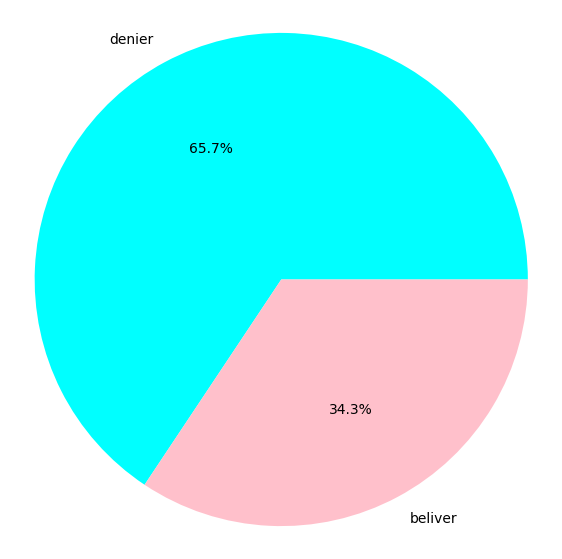

,index,sentiments
0,denier,3811
1,beliver,1994


In [ ]:
emotion = {0: "denier",
           1: "beliver"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
#plt.title("Dystrybucja sentymentów ", fontsize=20)
plt.show()
df_pie

In [ ]:
def get_sentiments(x, sent_dict):
    total = 0
    count = 0
    test = x["cleaned_tweet"].split()
    #print(test)
    for t in test:
        #print(t)
        if words_dict.get(t):
            total += int(sent_dict.get(t))
        count+=1
    avg = total/count
    sentiment = 1 if avg > 0.2 else 0
    return sentiment

In [ ]:
words_dict = dict(zip(words.words, words.cluster_value))

In [ ]:
data = data[data["cleaned_tweet"]!=""]

In [ ]:
data["sentiment"] = data.apply(get_sentiments, args=(words_dict,), axis=1)

In [ ]:
data["sentiment"].value_counts()

0    10800
1      873
Name: sentiment, dtype: int64

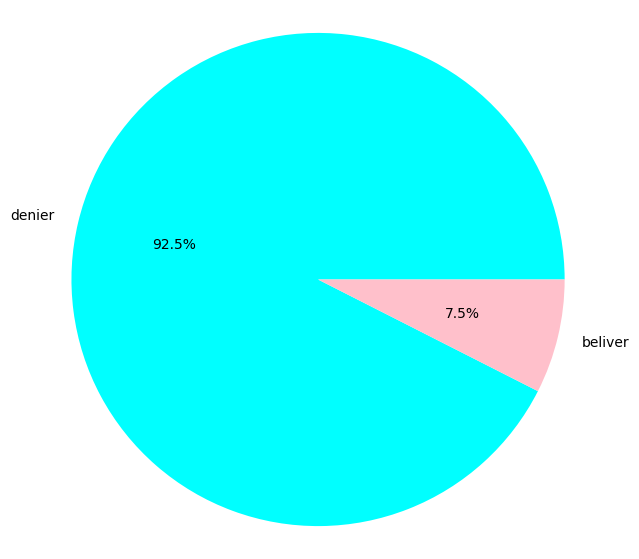

,index,sentiments_val
0,denier,10800
1,beliver,873


In [ ]:
emotion = {0: "denier",
           1: "beliver"}

data["sentiments_val"] = data["sentiment"].map(emotion)
df_pie = data["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink"]
plt.pie(df_pie["sentiments_val"],labels= df_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
#plt.title("Dystrybucja sentymentu w tweetach ", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
df_pie

In [ ]:
data_test = data[~data['test'].isna()] # tylko lista oznaczonych
data_train = data[data['test'].isna()] # tylko lista oznaczonych
data_test

,tweets,test,cleaned_tweet,sentiment,sentiments_val
39,@luvmywolfs @WBC241 Globalne ocieplenie jest ś...,0.0,mywolfs globalny ocieplenie ściema chwila okre...,0,denier
48,"Dzień dobry.\n\nZostało nam 14 lat, 354 dni, 1...",1.0,dzień dobry zostać rok dzień godzina minuta wy...,0,denier
58,"@jakubwiech @SDefence24 Coś takiego jak ""globa...",0.0,globalny ocieplenie istnieć zmiana klimat norm...,0,denier
60,@Margare18504431 @MarekSzolc Ale nie jest Pani...,1.0,świadomy globalny ocieplenie prowadzić mróz ra...,1,beliver
61,Przez zmiany klimatu ryby mogą stać się mniejs...,1.0,zmiana klimat ryba móc stać mały problem ekosy...,0,denier
...,...,...,...,...,...
1867,Sondaż: Polacy chcą aktywnych działań przeciw ...,1.0,sondaż Polak chcieć aktywny działanie przeciw ...,0,denier
1879,"Javier Gutiérrez, minister środowiska Nikaragu...",1.0,ier guti rrez minister środowisko nikaragui po...,1,beliver
1890,"@piotrdabrowsk19 @jakubwiech Ale skąd pomysł, ...",1.0,pomysł zmuszać chin usa inwestować przeciwdzia...,0,denier
1897,@MikaAngela11 @tomaawroblewski @FT Zdecydowana...,0.0,zdecydowany większość przeciwnik zielony ład z...,1,beliver


In [ ]:
data.to_csv('/content/drive/MyDrive/Praca dyplomowa/tweets_tagged.csv')

              precision    recall  f1-score   support

         0.0       0.57      0.93      0.71        54
         1.0       0.67      0.18      0.28        45

    accuracy                           0.59        99
   macro avg       0.62      0.55      0.49        99
weighted avg       0.62      0.59      0.51        99



Text(0.5, 1.0, 'Confusion Matrix')

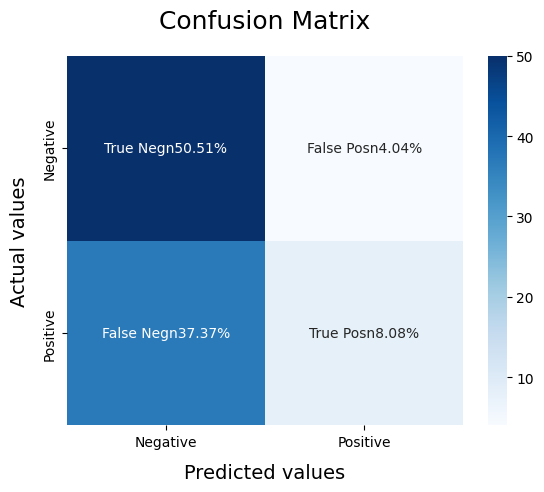

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


# Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
print(classification_report(data_test["test"], data_test["sentiment"]))

# Obliczamy i wyświetlamy confusion matrix
cf_matrix = confusion_matrix(data_test["test"], data_test["sentiment"])
categories = ['Negative','Positive'] #negative - not hamrmfull, positive - harmful
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
tagged = pd.read_csv("/content/drive/MyDrive/ZUM/tweets_tagged.csv", encoding="utf-8")

In [ ]:
tagged

,Unnamed: 0,tweets,cleaned_tweet,sentiment,sentiments_val
0,0,@gazeta_Mocarski @ela_kam___ @copone1dak Jedno...,zastanawiać wpływ ludzki ocieplenie klimat udo...,1,beliver
1,2,💬Posłanka @Ula_Zielińska o #ZielonyOdbudowy: G...,posłanek zielonyodbudowy globalny ocieplenie p...,1,beliver
2,3,💬Globalne ocieplenie powoduje coraz częstsze i...,globalny ocieplenie powodować częsty długo trw...,1,beliver
3,4,❗️Małgorzata Tracz - dodał(a) tweeta.\n🗨️ Treś...,małgorzata tracz dodać tweet treść globalny oc...,1,beliver
4,5,💬 – Globalne ocieplenie powoduje coraz częstsz...,globalny ocieplenie powodować częsty długo trw...,1,beliver
...,...,...,...,...,...
27297,32011,@wszewko Niby pogoda to nie klimat ale jak prz...,niby pogoda klimat przykurwi plus polsce lewac...,1,beliver
27298,32012,@wszewko To jest tragedia gorsza niż w komuniz...,tragedia zły komunizm niezachwiany wiara wznio...,1,beliver
27299,32013,Apel w sprawie końca Hiszpanii\n36-letni minis...,apel sprawa koniec hiszpanii letny minister al...,1,beliver
27300,32014,@zbigius @AlbertMarten1 Mają dużo wspólnego z ...,mieć wspólny globalny ocieplenie obserwować wz...,1,beliver
